In [11]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_manager import LoacalDatasource
from factor_engine import register_factor, FactorEngine, list_factors
from evaluation.engine import EvaluatorEngine

In [12]:
# 显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题
# 过滤警告
warnings.filterwarnings('ignore')

In [13]:
local_datasource = LoacalDatasource(file_path="./data/daily_price.parquet")
df = local_datasource.load_data(start="2020-01-01", end="2026-01-01")

In [14]:
print(df.columns.to_list())

['open', 'high', 'low', 'close', 'volume', 'amount', 'market_cap_float', 'market_cap_total', 'limit_status']


In [15]:
# 因子引擎
factor_engine = FactorEngine()
# 因子评价
evaluator_engine = EvaluatorEngine()

In [16]:
# 使用已经写好的因子
# factor_name = ""
# factor: pd.Series = factor_engine.compute_one(df, factor_name)

# 自定义因子模版
# factor_name = "custom_factor"
# @register_factor(
#     name=factor_name,
#     required_fields=["close"],
# )
# def factor_func(df: pd.DataFrame) -> pd.Series:
#     return df["close"]

factor_name = "涨跌停乘量额因子"
@register_factor(
    name=factor_name,
    required_fields=["open", "close", "amount"],
    force_update=True,
)
def factor_func(df: pd.DataFrame) -> pd.Series:
    def cal(g) -> pd.Series:
        mean = ((np.log(g["close"] / g["open"])) * g["amount"]).median()
        up_power =  ((np.log(g["close"] / g["open"])) * g["amount"] - mean) ** 2
        return up_power
    
    factor = df.groupby("date").apply(cal)
    factor.index = factor.index.droplevel(0)
    return factor

In [17]:
reports = evaluator_engine.evaluate_multi_horizons(
    df=df,
    factor=factor_engine.compute_one(df, factor_name),
    horizons=[1],
    evaluator="common_eval"
)

In [18]:
for horizon, report in reports.items():
    print(f"=== 持有期: {horizon} 天 ===")
    print(report.metrics)

=== 持有期: 1 天 ===
{'ic_mean': np.float64(-0.00919462845933187), 'ic_std': np.float64(0.04675051794373671), 'ic_ir': np.float64(-0.19667436562729457), 'ic_t': np.float64(-6.844154891651881), 'rank_ic_mean': np.float64(-0.06573858280787234), 'rank_ic_std': np.float64(0.11061111768711716), 'rank_ic_ir': np.float64(-0.5943216575554854), 'rank_ic_t': np.float64(-20.682052115939417), 'top_turnover_20_mean': np.float64(0.42035643248876653), 'monotonic_mean': np.float64(-0.15583915121487374), 'group_ls_mean': np.float64(-0.002392789749976415), 'group_ls_t': np.float64(-8.166423434059269)}


=== 持有期: 1 天 ===


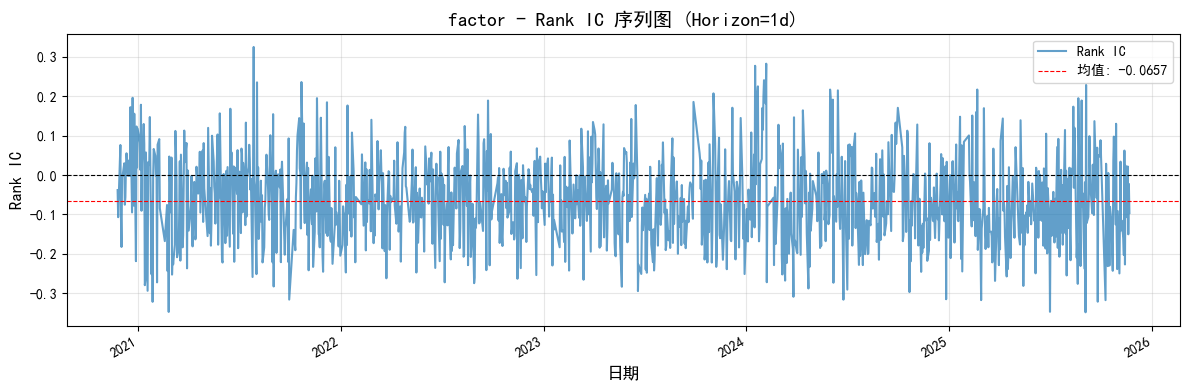

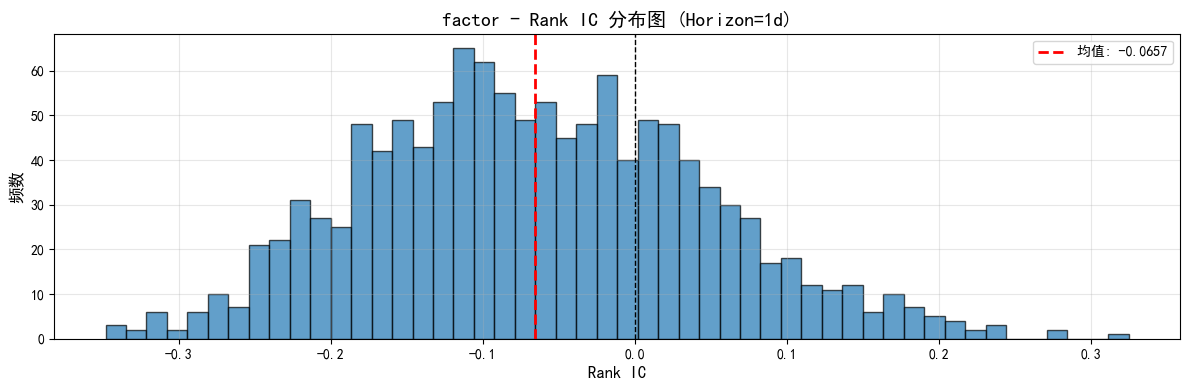

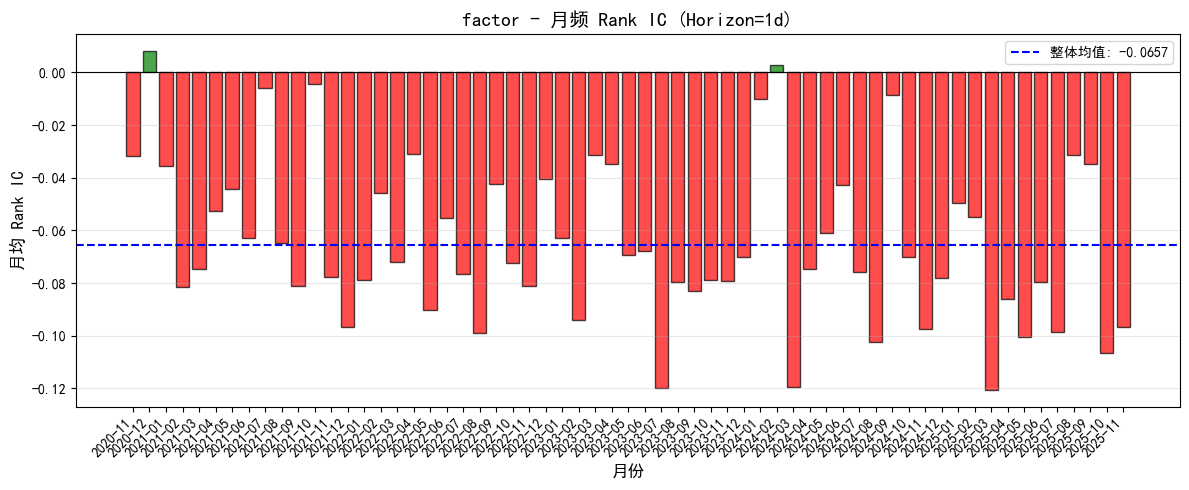

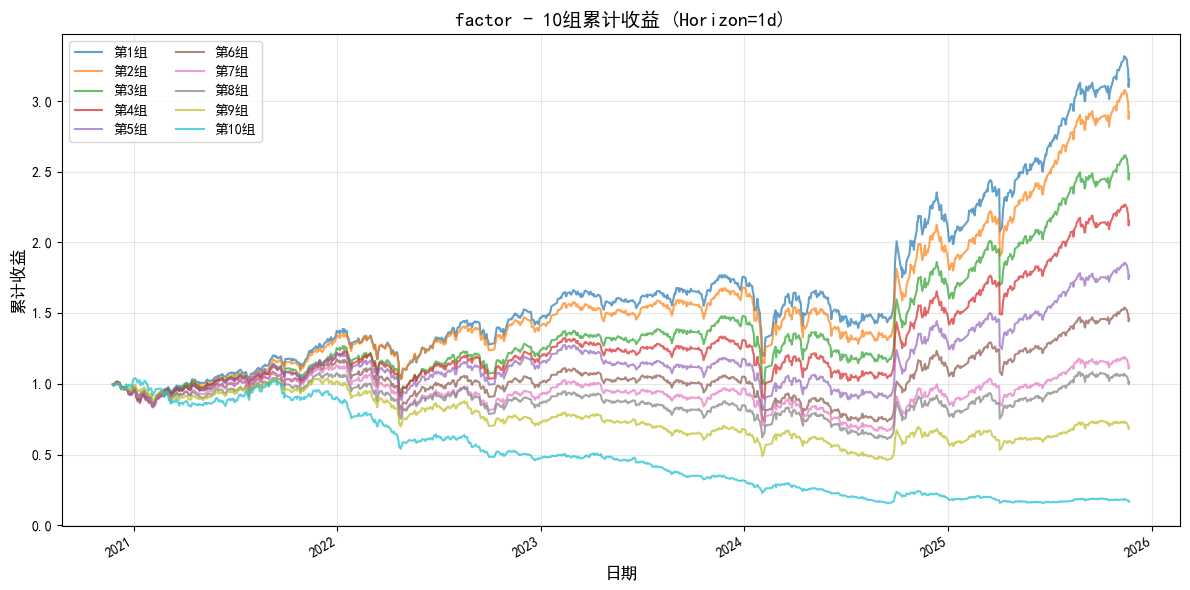

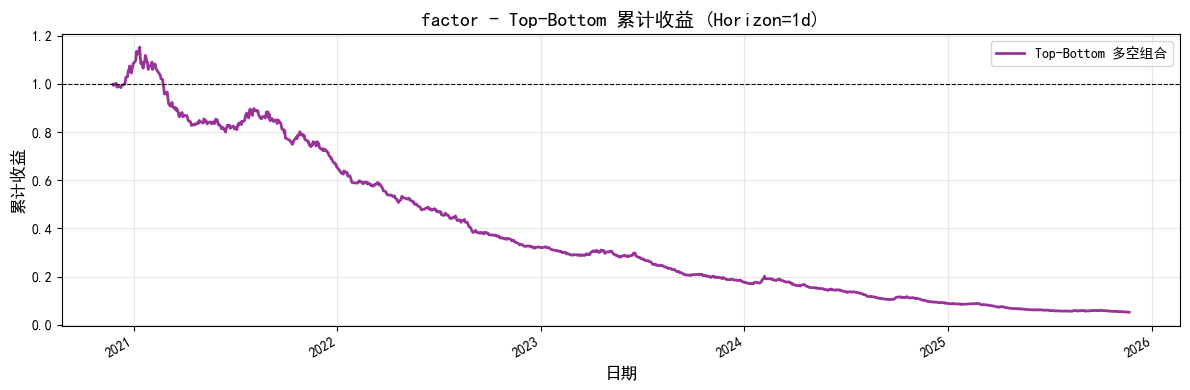

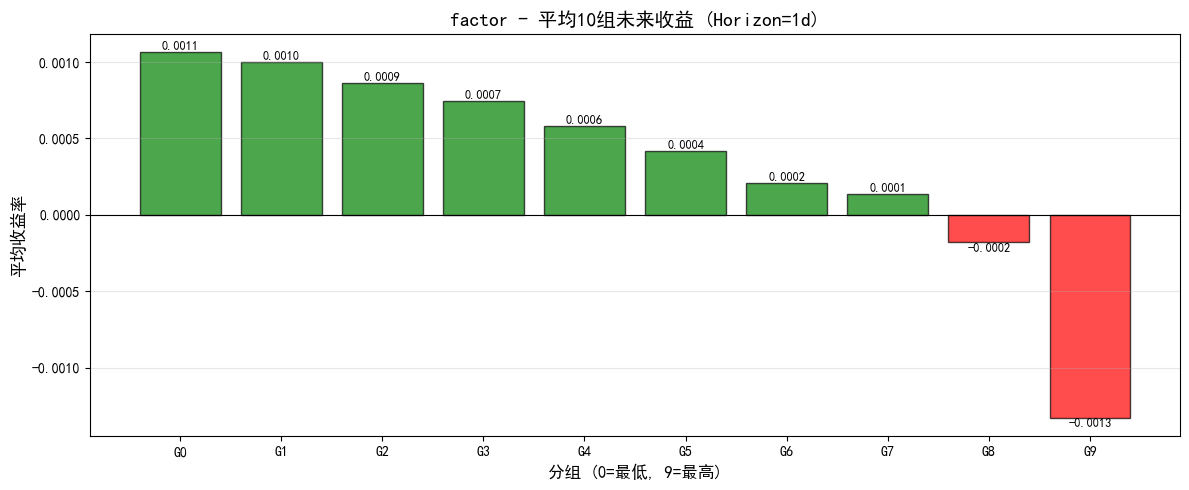

In [19]:
for horizon, report in reports.items():
    print(f"=== 持有期: {horizon} 天 ===")
    report.plot_artifacts(show_fig=True)